# 1. Image Preprocessing

[Receipt OCR Part 1](https://www.kaggle.com/code/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv/notebook)

[Receipt OCR Part 2](https://www.kaggle.com/code/dmitryyemelyanov/receipt-ocr-part-2-text-recognition-by-tesseract/notebook)

In [1]:
from skimage.filters import threshold_local

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
IMAGE_PATH = "../images/test-01.jpg"

In [3]:
def plot_gs(image, size=(16, 10)):
    plt.figure(figsize=size)

    return plt.imshow(image, cmap="Greys_r")


def plot_rgb(image, size=(16, 10)):
    plt.figure(figsize=size)

    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


def resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)

    return cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)


def warp_perspective(image, rectangle):
    (tl, tr, br, bl) = rectangle

    width_a = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_b = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    height_a = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_b = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    max_width = max(int(width_a), int(width_b))
    max_height = max(int(height_a), int(height_b))

    destination = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1],
    ], dtype="float32")

    transformation = cv2.getPerspectiveTransform(rectangle, destination)

    return cv2.warpPerspective(image, transformation, (max_width, max_height))


def approximate_contour(contour):
    perimeter = cv2.arcLength(contour, True)

    return cv2.approxPolyDP(contour, 0.032 * perimeter, True)


def get_receipt_contour(contours):
    for contour in contours:
        approximation = approximate_contour(contour)

        if len(approximation) == 4:
            return approximation

        
def get_receipt_rectangle(contour, ratio):
    points = contour.reshape(4, 2)
    rectangle = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    rectangle[0] = points[np.argmin(points_sum)]
    rectangle[2] = points[np.argmax(points_sum)]

    difference = np.diff(points, axis=1)
    rectangle[1] = points[np.argmin(difference)]
    rectangle[3] = points[np.argmax(difference)]

    return rectangle / ratio

## 1.1 Load image

In [4]:
image_og = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)

## 1.2 View image

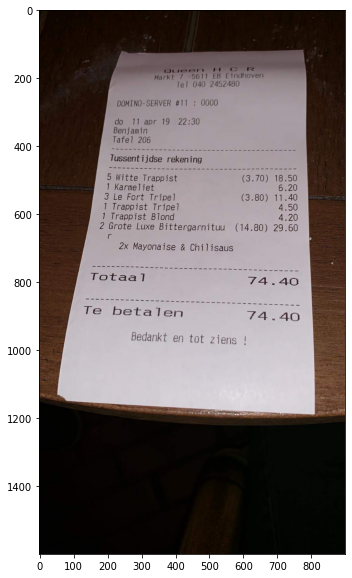

In [5]:
plot_rgb(image_og)

## 1.3 Downscale image

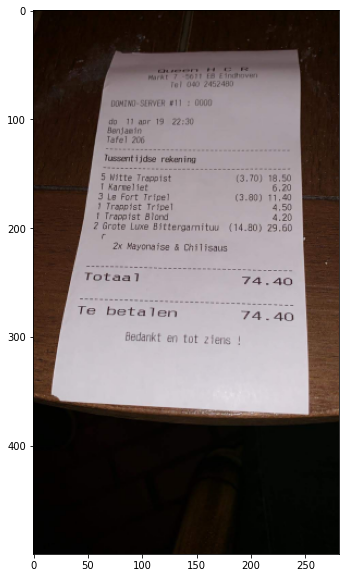

In [6]:
ratio = 500 / image_og.shape[0]
image_rgb = resize(image_og, ratio)

plot_rgb(image_rgb)

## 1.4 Greyscale image

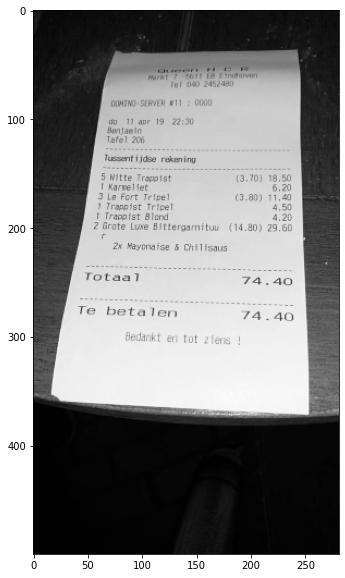

In [7]:
image_gs = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

plot_gs(image_gs)

## 1.5 Remove noise

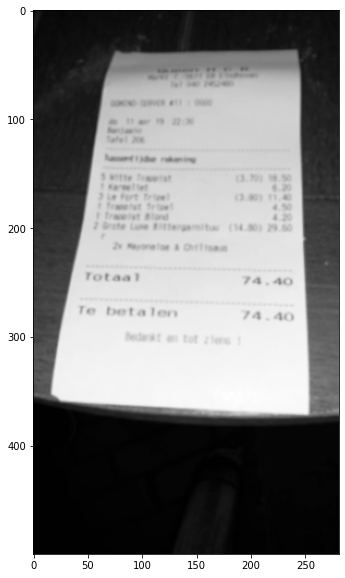

In [8]:
image_gs_blur = cv2.GaussianBlur(image_gs, (5, 5), 0)

plot_gs(image_gs_blur)

## 1.6 Detect white regions

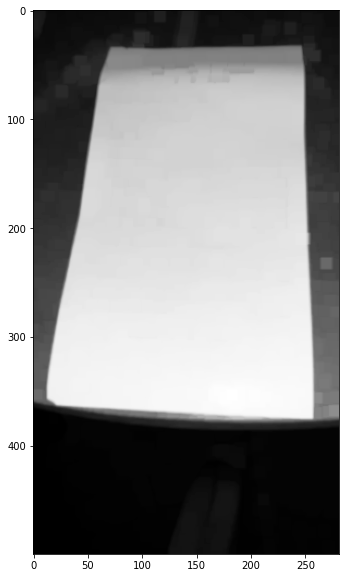

In [9]:
rectangle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
image_gs_blur_dilate = cv2.dilate(image_gs_blur, rectangle_kernel)

plot_gs(image_gs_blur_dilate)

## 1.7 Detect edges

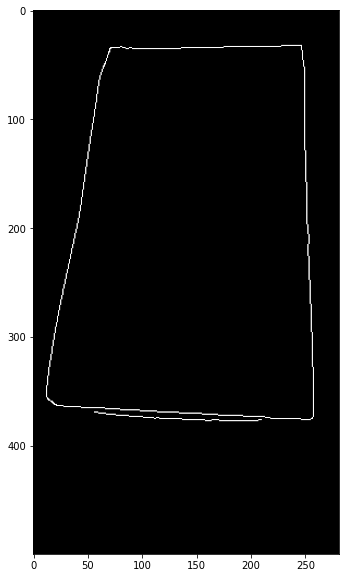

In [10]:
image_gs_blur_dilate_edges = cv2.Canny(image_gs_blur_dilate, 100, 200, apertureSize=3)

plot_gs(image_gs_blur_dilate_edges)

## 1.8 Detect contours

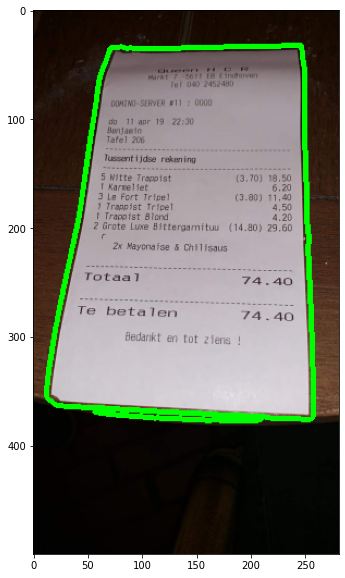

In [11]:
contours, hierarchy = cv2.findContours(image_gs_blur_dilate_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

image_rgb_contours = cv2.drawContours(image_rgb.copy(), largest_contours, -1, (0, 255, 0), 3)

plot_rgb(image_rgb_contours)

## 1.9 Detect receipt contour

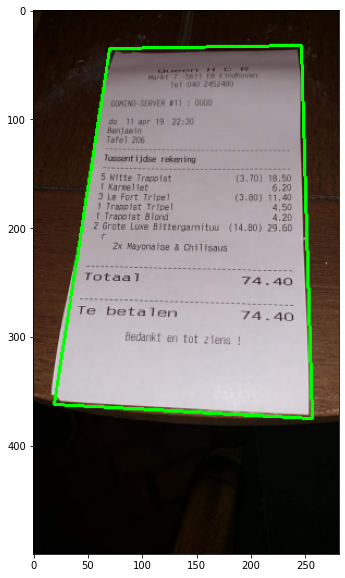

In [12]:
receipt_contour = get_receipt_contour(largest_contours)

image_rgb_receipt_contour = cv2.drawContours(image_rgb.copy(), [receipt_contour], -1, (0, 255, 0), 2)

plot_rgb(image_rgb_receipt_contour)

## 1.10 Warp perspective

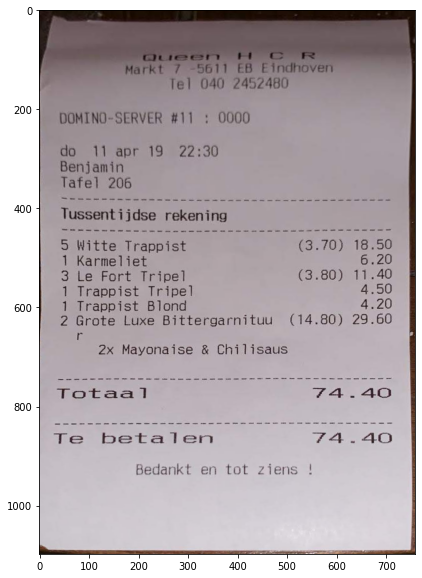

In [13]:
image_og_warp = warp_perspective(image_og.copy(), get_receipt_rectangle(receipt_contour, ratio))

plot_rgb(image_og_warp)

## 1.11 Scan image

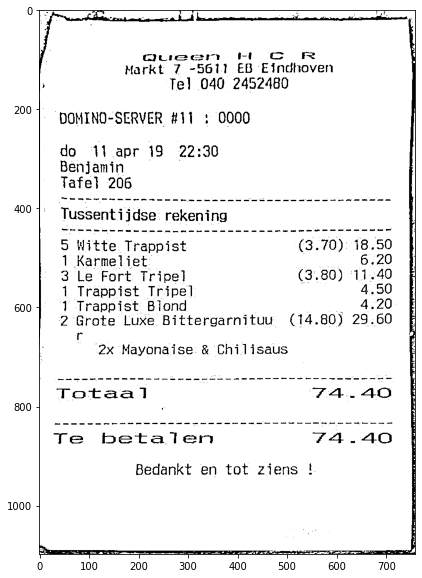

In [14]:
image_og_warp_gray = cv2.cvtColor(image_og_warp, cv2.COLOR_BGR2GRAY)
threshold = threshold_local(image_og_warp_gray, 21, offset=5, method="gaussian")

image_og_warp_scan = (image_og_warp_gray > threshold).astype("uint8") * 255

plot_gs(image_og_warp_scan)